### Data Analysis, exploration and model experimentation

Firstly, let's import the data and check how its columns are presented

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import radians, sin, cos, sqrt, tan, atan2, exp
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from category_encoders import LeaveOneOutEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data\deliverytime.csv")

In [7]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),Delivery_Distance_km,time_over_dist
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,3.026099,7.931003
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,20.189866,1.634483
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,1.553245,16.739147
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,7.792847,2.694779
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,6.212087,4.829295


In [3]:
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min)
count,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,29.544075,4.632367,17.017729,70.231332,17.465186,70.845702,26.294607
std,5.696793,0.327708,8.185109,22.883647,7.335122,21.118812,9.383806
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.600000,12.933284,73.170000,12.988453,73.280000,19.000000
50%,29.000000,4.700000,18.546947,75.898497,18.633934,76.002574,26.000000
75%,34.000000,4.800000,22.728163,78.044095,22.785049,78.107044,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,54.000000


In [18]:
df.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
Time_taken(min)                0
dtype: int64

As we can see above, we have a dataset with 11 columns: Two of them (ID and Delivery_person_ID) are used for the row's representation, not actually being features that can explain our output. Regarding the output, it is given by the Time_taken(min) column, which represents the amount of time, in mminutes, the delivery person took to deliver the customer's after picking up the order at the respective restaurant. All the remaining columns can be treated and used in experiments to find out if they can be used as explainable features regarding our target.

The distance between the restaurant and the customer's location is, very likely, an important feature, since intuitively we can say that the greater the distance between two points, in average (not considering speed here), the higher the amount of time to traverse this distance. And to obtain this information, we can use the latitude and longitude associated with each point on earth. The function below helps us obtain the distance between point 1 (Rest_Lat; Rest_Lon) and point 2 (Dest_Lat; Dest_Lon).

 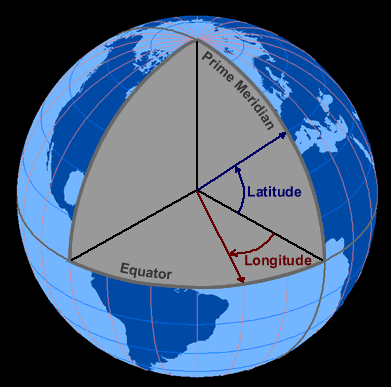

In [9]:
def distance_calc(Rest_Lat, Rest_Lon, Dest_Lat, Dest_Lon):
    
    R = 6373.0

    lat1 = radians(Rest_Lat)
    lon1 = radians(Rest_Lon)
    lat2 = radians(Dest_Lat)
    lon2 = radians(Dest_Lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

df['Delivery_Distance_km'] = df.apply(lambda x: distance_calc(x.Restaurant_latitude, x.Restaurant_longitude, x.Delivery_location_latitude, x.Delivery_location_longitude), axis=1)

Before continuing, it is a very good practice to try to identify and remove potential outliers in our dataset. In order to do this, we will study deliveries that took either too much time to travel small distances or deliveries that took too little time to travel big distances, all statistically speaking. So, we are creating an auxiliary variable given by the time taken to make the delivery divided by the previously calculated distance (min/km). Why not using only the Time Taken in minutes? Because if we did that we could be accusing deliveries with distances bigger than normal, for example, as potential outliers regarding the time taken to make the delivery, which is not necessarally true.

In [10]:
df['time_over_dist'] = df['Time_taken(min)']/df['Delivery_Distance_km']

Let's check the distribution of the time over distance auxiliary variable:

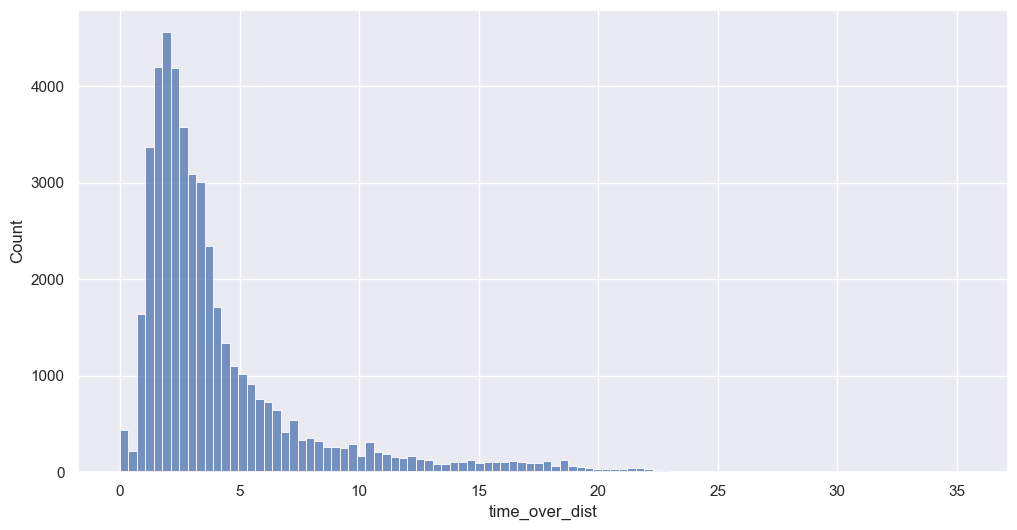

In [41]:
plt.figure(figsize=(12,6))
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set(style="darkgrid")
sns.histplot(data=df, x="time_over_dist", bins=100)
plt.show()

We can see that it does not follow a normal distribution, but a skewed distribution with a right tail, meaning that there are more outliers way bigger than the mean value. How can we check for potential outliers in a skewed distribution? Simply using 1.5*IQR won't do the job, since it works well only with normal distributions.

So, by researching outlier detection methods for skewed distributions we can find Hubert, M. and Vandervieren, E. (2008) method which empirically proposed adjustments in the boxplot's whiskers with the aid of the medcouple variable. The medcouple measures a distribution's skewness, where 

"a distribution that is skewed to the right has a positive value for the medcouple, whereas the MC becomes negative at a left skewed distribution. Finally, a symmetric distribution has a zero medcouple." - https://rpubs.com/dario-dellevedove/601843

In the link above, one can check in more details the method mentioned. Now, let's build a function that applies this outlier detection.

In order to calculate the Medcouple, we first tried to use the medcouple function available in statsmodels library. However, it is very expensive memory-wise, not being a great method when using big datasets (which could be our situation in the future) . In order to try to correct this, with the aid of AI orientation (chatGPT) we found a solution to calculate Medcouple using generators. They allow us to iterate over large datasets without loading the entire dataset into memory.

In [11]:
def outliers_limits(col):
    def medcouple_generator(data, chunk_size=9**9999):
        for chunk in range(0, len(data), chunk_size):
            yield data[chunk:chunk + chunk_size]

    def calculate_medcouple(data):
        deviations = np.abs(data - np.median(data))
        q75, q25 = np.percentile(deviations, [75, 25])
        medcouple = (q75 - q25) / (q75 + q25)

        return medcouple

    data_generator = medcouple_generator(col.values)
    medcouple_values = []
    
    for chunk in data_generator:
        medcouple_values.append(calculate_medcouple(chunk))

    final_medcouple = np.median(medcouple_values)
    if final_medcouple >= 0:
        lower_bound = np.percentile(col, 25) - 1.5*(math.exp(-4*final_medcouple))*(np.percentile(col, 75) - np.percentile(col, 25))
        upper_bound = np.percentile(col, 75) + 1.5*(math.exp(3*final_medcouple))*(np.percentile(col, 75) - np.percentile(col, 25))
    else:
        lower_bound = np.percentile(col, 25) - 1.5*(math.exp(-3*final_medcouple))*(np.percentile(col, 75) - np.percentile(col, 25))
        upper_bound = np.percentile(col, 75) + 1.5*(math.exp(4*final_medcouple))*(np.percentile(col, 75) - np.percentile(col, 25))
    return lower_bound, upper_bound

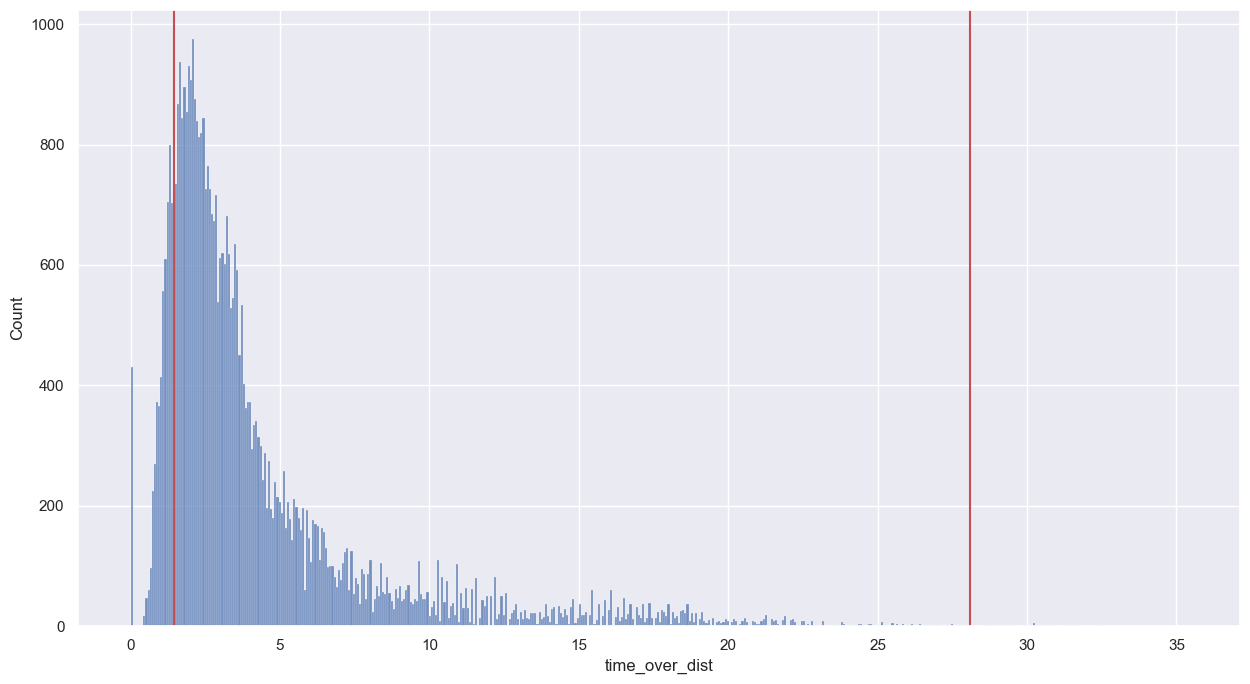

In [43]:
plt.figure(figsize=(15,8))
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set(style="darkgrid")
sns.histplot(data=df, x="time_over_dist", bins=500)
plt.axvline(x=(outliers_limits(df['time_over_dist'])[0]), color='r')
plt.axvline(x=(outliers_limits(df['time_over_dist'])[1]), color='r')
plt.show()

Having calculated the new boxplot whiskers for the skewed distribution, let's filter out the datapoints that fall within the potential outlier zone in order to proceed with the training processess later on without their influence.

In [12]:
df = df.loc[(df['time_over_dist'] > outliers_limits(df['time_over_dist'])[0]) & 
            (df['time_over_dist'] < outliers_limits(df['time_over_dist'])[1])]

In [13]:
# Remodeling our dataset to have only our potential features and our target feature

df = df[['Delivery_person_Age', 'Delivery_person_Ratings', 'Type_of_order',	'Type_of_vehicle', 'Time_taken(min)', 'Delivery_Distance_km']]


In [121]:
df.isnull().sum()

Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Delivery_person_Age            0
Delivery_person_Ratings        0
Type_of_order                  0
Type_of_vehicle                0
Time_taken(min)                0
Delivery_Distance_km           0
latitude_aux                   0
longitude_aux                  0
dtype: int64

In [42]:
df.describe()

,Delivery_person_Age,Delivery_location_latitude,Delivery_location_longitude,Restaurant_latitude,Restaurant_longitude,Delivery_person_Ratings,Time_taken(min),Delivery_Distance_km,delivery_location_aux_sum,restaurant_aux_sum,restaurant_aux_div,delivery_location_aux_div
count,39517.000000,39517.000000,39517.000000,39517.000000,39517.000000,39517.000000,39517.000000,39517.000000,39517.000000,39517.000000,36353.000000,39517.000000
mean,29.868285,17.411117,70.804756,17.353623,70.747263,4.617031,27.394159,8.803685,88.215873,88.100886,0.245834,0.306736
std,5.684958,7.305497,21.140702,7.304447,21.140416,0.335140,9.291590,5.161568,26.722597,26.721568,0.071403,0.215677
min,15.000000,0.010000,0.010000,0.000000,0.000000,1.000000,10.000000,1.465527,0.020000,0.000000,0.130505,0.130619
25%,25.000000,12.983298,73.257753,12.934179,73.170283,4.500000,20.000000,4.590707,90.590520,90.547591,0.166633,0.167383
50%,30.000000,18.623626,75.983400,18.554382,75.898497,4.700000,27.000000,7.805079,93.417894,93.306164,0.259878,0.263328
75%,35.000000,22.774648,78.088890,22.728163,78.044095,4.800000,33.000000,12.296482,98.741266,98.638642,0.299496,0.304985
max,50.000000,31.054057,88.563452,30.914057,88.433452,6.000000,54.000000,20.976072,111.262810,111.002810,0.407623,1.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Time_taken(min)              45593 non-null  int64  
 11  Delivery_Distance_km         45593 non-null  float64
 12  time_over_dist               45593 non-null  float64
dtypes: float64(7), i

c:\Users\artur\anaconda3\envs\fl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


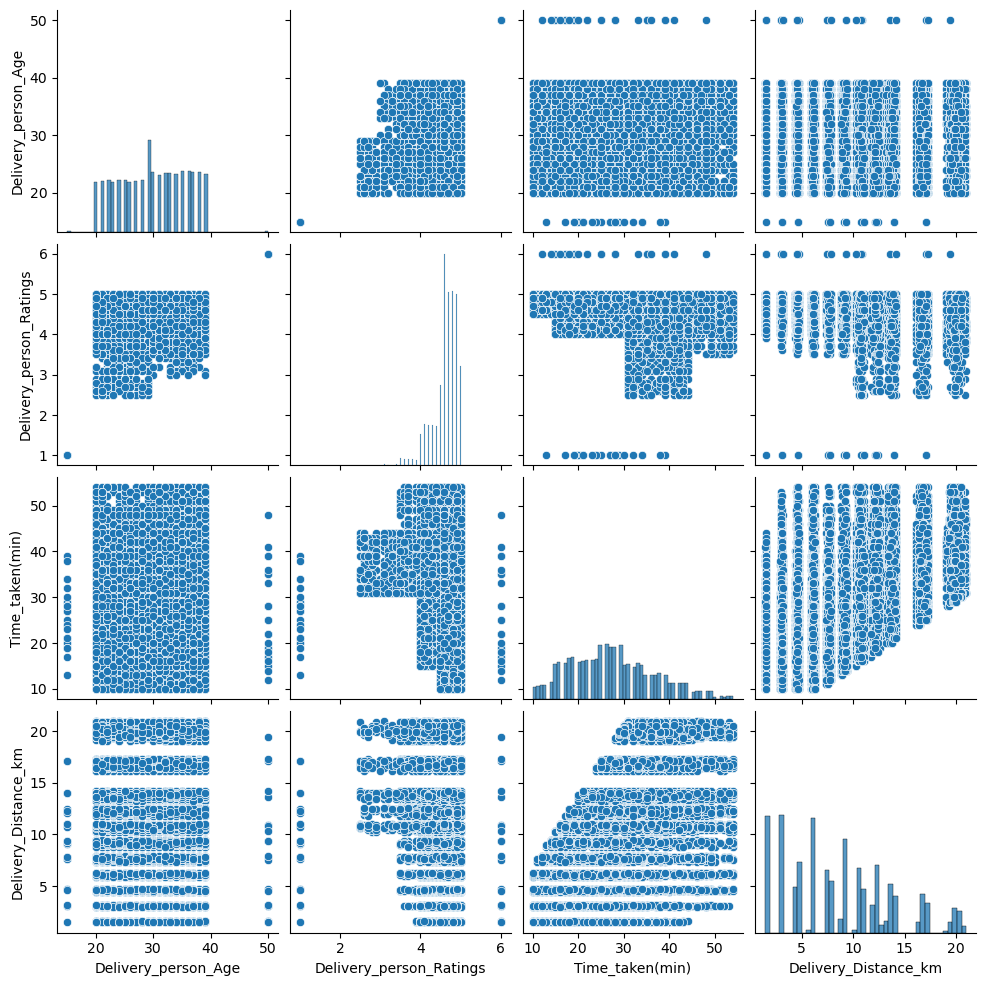

In [75]:
sns.pairplot(df)
plt.show()

Above, we plotted a pairplot visual, from seaborn, that lets us visualize the relation between all numeric variables in our dataset. From it, we can check the following:


i__ Delivery person ratings range from 0 to 6, as we can see. And, generally, people with higher ratings have higher chances to make deliveries in lower times;

ii__ The majority of the deliveries were made in distances lower than +- 15 km;

iii__ Generally, deliveries made in bigger distances take longer to be completed, as we can see the increasing behaviour of the time taken when the distance increases.

Also, below we are plotting two boxplot graphs: one to study the distribution of the time taken (min) for every type of vehicle and another to study it for every type of order.

With neither of them we can see much distinction between every category regarding the time taken do make the delivery. However, with the vehicle type, we can slightly see a more significant difference between the motorcycle and the rest of the vehicles.

Let's keep the vehicle type feature and apply the folowing simple transformation: create a column informing if the vehicle used was a motorcycle or not, since deliveries made using a motorcycle have higher tendency to take longer when comparing to the rest of the vehicles. However, we will remove the type of order feature since it will not offer us much explanation regarding the time taken to make the delivery, which means it can be a redundant variable that, if kept inside the model, can be harmful to the training of the model and posterior generalization capacity.

Type_of_order
Snack      9986
Meal       9953
Drinks     9799
Buffet     9779
Name: count, dtype: int64

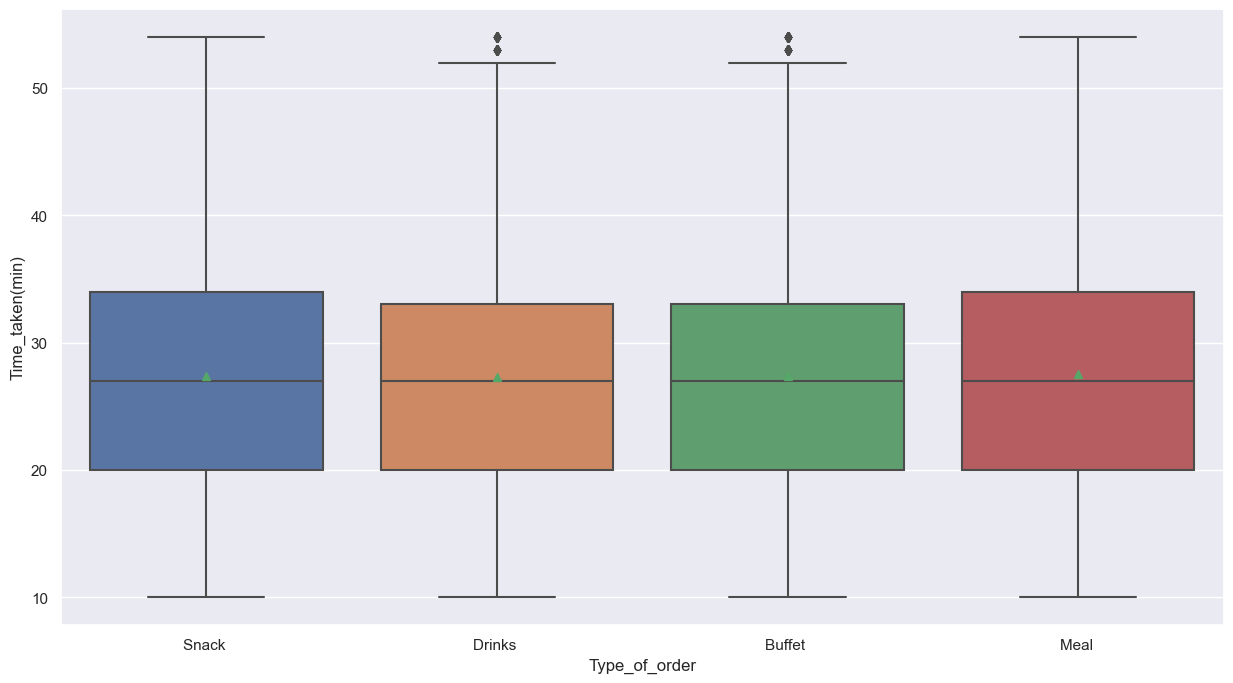

In [54]:
plt.figure(figsize=(15,8))
sns.boxplot(x=df['Type_of_order'], y='Time_taken(min)', data=df, showmeans=True)
df['Type_of_order'].value_counts()

Type_of_vehicle
motorcycle           23434
scooter              12842
electric_scooter      3191
bicycle                 50
Name: count, dtype: int64

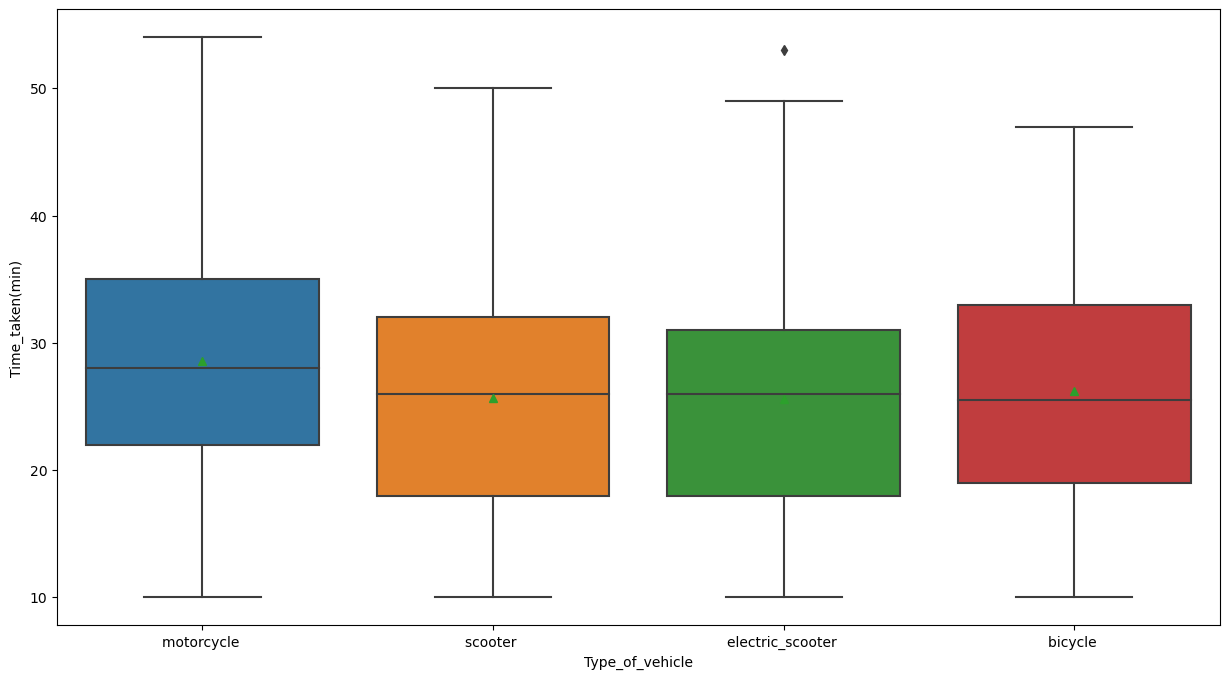

In [76]:
plt.figure(figsize=(15,8))
sns.boxplot(x=df['Type_of_vehicle'], y='Time_taken(min)', data=df, showmeans=True)
df['Type_of_vehicle'].value_counts()

In [108]:
df["is_motorcycle"] = np.where(df["Type_of_vehicle"].str.contains("motorcycle"), 1, 0)

is_motorcycle
1    23434
0    16083
Name: count, dtype: int64

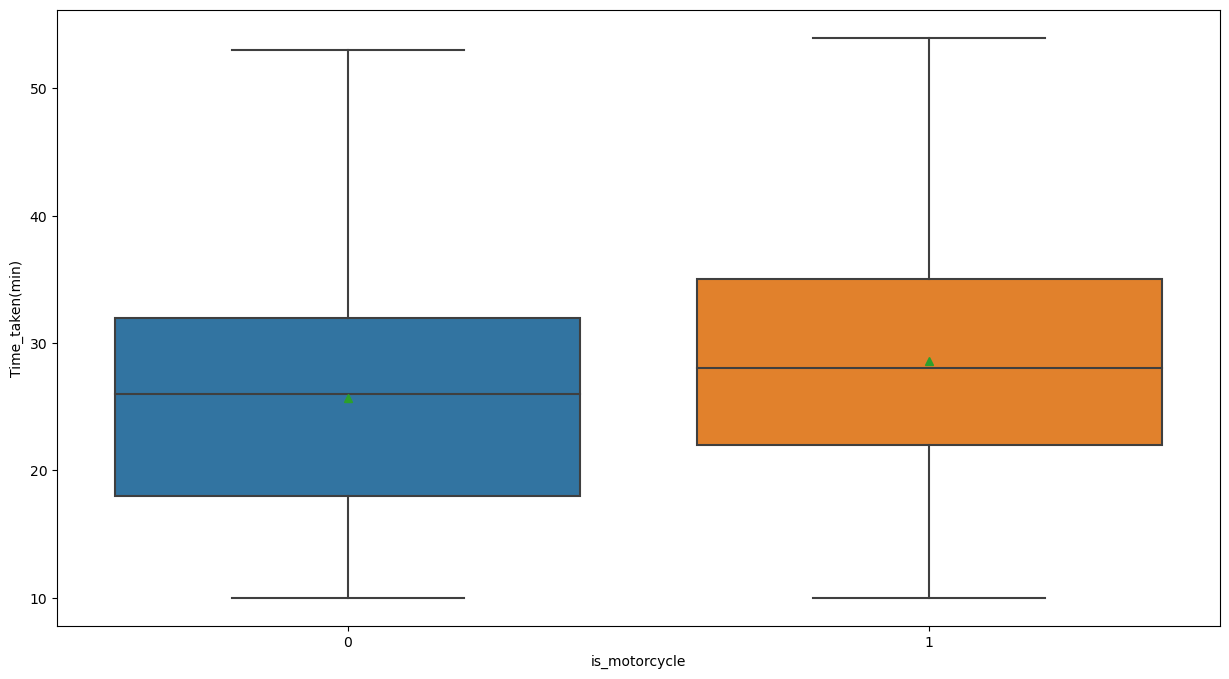

In [78]:
plt.figure(figsize=(15,8))
sns.boxplot(x=df['is_motorcycle'], y='Time_taken(min)', data=df, showmeans=True)
df['is_motorcycle'].value_counts()

In [79]:
df

,Delivery_person_Age,Delivery_person_Ratings,Type_of_order,Type_of_vehicle,Time_taken(min),Delivery_Distance_km,is_motorcycle
0,37,4.9,Snack,motorcycle,24,3.026099,1
1,34,4.5,Snack,scooter,33,20.189866,0
2,23,4.4,Drinks,motorcycle,26,1.553245,1
3,38,4.7,Buffet,motorcycle,21,7.792847,1
4,32,4.6,Snack,scooter,30,6.212087,0
...,...,...,...,...,...,...,...
45588,30,4.8,Meal,motorcycle,32,1.490314,1
45589,21,4.6,Buffet,motorcycle,36,11.011190,1
45590,30,4.9,Drinks,scooter,16,4.658657,0
45591,20,4.7,Snack,motorcycle,26,6.234350,1


In [14]:
df = df.drop(['Type_of_order', 'Type_of_vehicle'], axis=1)

Let's check all features' relation to our target "Time Taken (min)" to see their respective explainability regarding this output. We want to use features that can provide explanation and information gain when trying to predict the time taken to make the delivery. This is essential because this kind of feature can actually make our model learn patterns and predict on new data, generalizing well.

In order to do this, let's use three simple techniques: heatmaps (using pearson and spearman correlations) and feature importance when applied to a general random forest regressor model, which will check how big is the information gain related to a feature when we split it in different groups: does it, between the formed groups on the split, reduce the variance of our numeric target? If yes, we have a feature with good explainability.

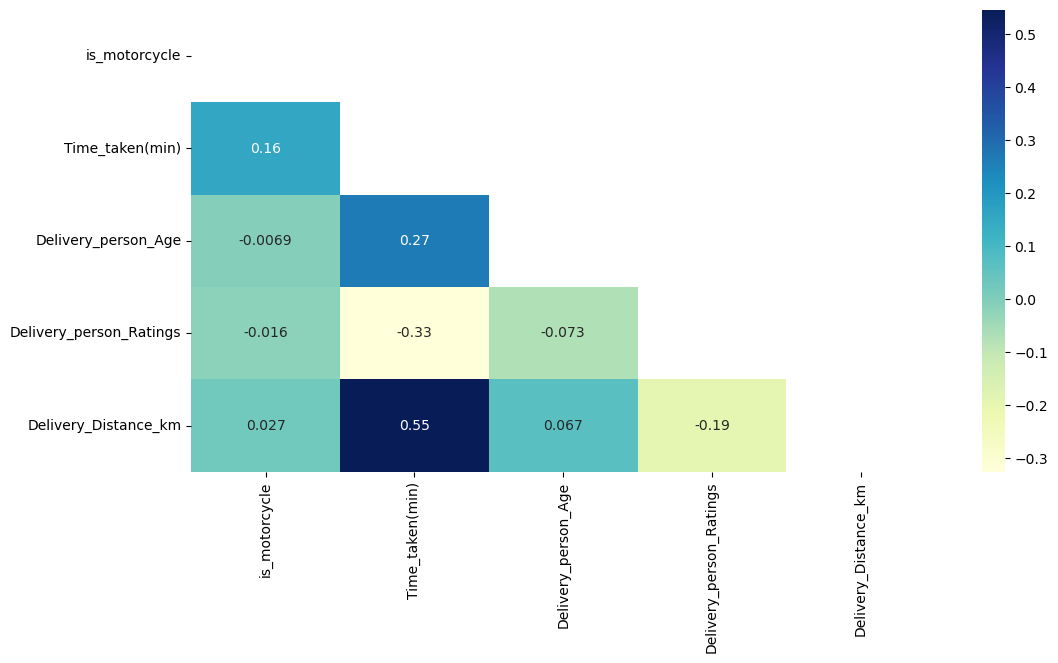

In [81]:
plt.figure(figsize=(12,6))
mask = np.triu(np.ones_like(df[['is_motorcycle','Time_taken(min)','Delivery_person_Age', 'Delivery_person_Ratings', 'Delivery_Distance_km']].corr()))
dataplot=sns.heatmap(df[['is_motorcycle','Time_taken(min)', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Delivery_Distance_km']].corr(method='pearson'), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

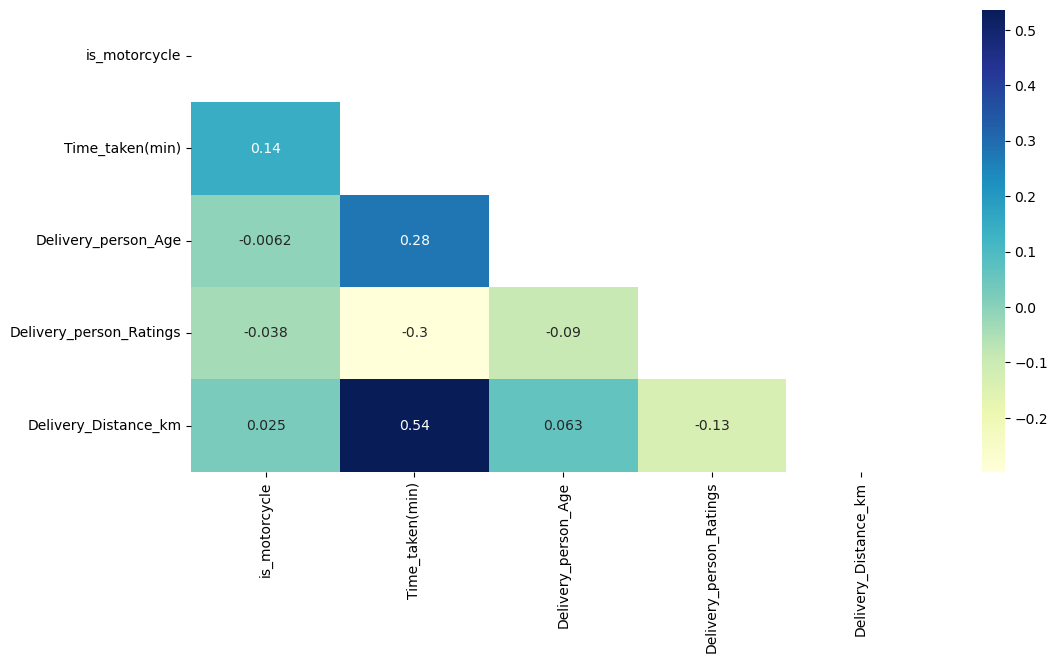

In [82]:
plt.figure(figsize=(12,6))
mask = np.triu(np.ones_like(df[['is_motorcycle','Time_taken(min)', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Delivery_Distance_km']].corr()))
dataplot=sns.heatmap(df[['is_motorcycle','Time_taken(min)', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Delivery_Distance_km']].corr(method='spearman'), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

c:\Users\artur\anaconda3\envs\fl\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


<BarContainer object of 4 artists>

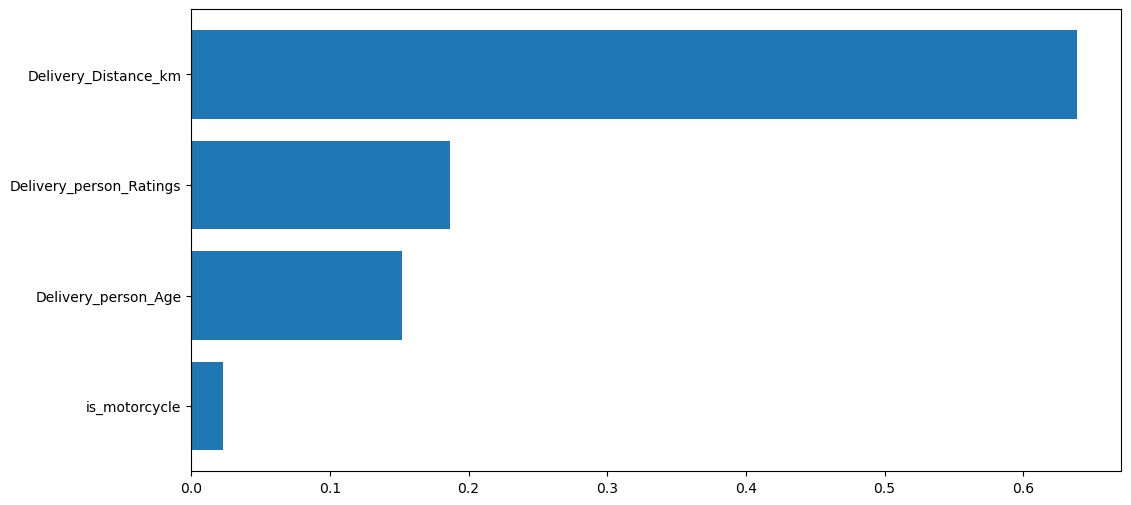

In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

X = df[['is_motorcycle', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Delivery_Distance_km']]
Y = df[['Time_taken(min)']]

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, Y)

plt.figure(figsize=(12,6))
plt.barh(X.columns, rf.feature_importances_)

In [84]:
rf.feature_importances_

array([0.02309424, 0.15174616, 0.18641495, 0.63874466])

The delivery distance is the feature that explains the most our target (the time taken to make the delivery) as seen not only in the pairplot but also with the feature importance above and the pearson ansd spearman coefficients. We are going to proceed with the four features listed in the feature importance visual above: delivery distance, deivery person ratings, delivery person's age and if the vehicle used is a motorcycle or not, in order to explain and predict our target: the time taken to make the delivery (go from restaurant to the delivery location).

In [85]:
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Time_taken(min),Delivery_Distance_km,is_motorcycle
count,39517.000000,39517.000000,39517.000000,39517.000000,39517.000000
mean,29.868285,4.617031,27.394159,8.803685,0.593011
std,5.684958,0.335140,9.291590,5.161568,0.491279
min,15.000000,1.000000,10.000000,1.465527,0.000000
25%,25.000000,4.500000,20.000000,4.590707,0.000000
50%,30.000000,4.700000,27.000000,7.805079,1.000000
75%,35.000000,4.800000,33.000000,12.296482,1.000000
max,50.000000,6.000000,54.000000,20.976072,1.000000


We have our dataset set for training and testing! Outliers removed and feature selection done.


We are now proceeding with training and testing various regression models using their respective standard hyperparameters in order to identify the best model for our problem.

Below, a script was bulit to do all these tasks for us using k-fold cross-validation (k=3 folds). However, since we need to standarize data throghout the feature engineering process, we have to apply these techniques before each fold: At each fold, we use different training and testing sets. So, in order to avoid data leakage, we need to apply the standarization before each fold in order to have a correct comparison across the models.

We are going to test 5 models: Random Forest Regressor, XGBoost Regressor, K-NN Regression, SVM Regressor and Decision Tree Regressor. Also, we are calculating various important metrics regarding regression problems: RMSE, MAE, MSE, R2 and MAPE in order too compare the models in detail.

Since we are testing k-nn and support vector machine, we need to standardize our numerical features, using, in this case, StandardScaler, so we can really test this model efficiently, since it compares across features (their dimensionality matters).

In [87]:
df

,Delivery_person_Age,Delivery_person_Ratings,Time_taken(min),Delivery_Distance_km,is_motorcycle
0,37,4.9,24,3.026099,1
1,34,4.5,33,20.189866,0
2,23,4.4,26,1.553245,1
3,38,4.7,21,7.792847,1
4,32,4.6,30,6.212087,0
...,...,...,...,...,...
45588,30,4.8,32,1.490314,1
45589,21,4.6,36,11.011190,1
45590,30,4.9,16,4.658657,0
45591,20,4.7,26,6.234350,1


In [ ]:
# Assuming df is your DataFrame
x_input = df.drop(['Time_taken(min)'], axis=1)
y_output = df['Time_taken(min)']


X_train, X_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.15, random_state=42)

# Define the number of folds (k)
k = 3

# Initialize your KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define a list of models to evaluate
models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "XGBoostRegressor": XGBRegressor(),
    "SVMRegressor": SVR(),
    "DecisionTreeRegressor": DecisionTreeRegressor()
}

model_metrics = {}

for model_name, model in models.items():
    fold_metrics = {
        "MSE": [],
        "MAE": [],
        "MAPE": [],
        "R2": [],
        "RMSE": []
    }

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        standarization = StandardScaler()    
        X_train_fold[['Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings']] = standarization.fit_transform(X_train_fold[['Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings']])
        X_val_fold[[ 'Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings']] = standarization.transform(X_val_fold[['Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings']])

        model.fit(X_train_fold, y_train_fold.values.ravel())
        y_pred = model.predict(X_val_fold)

        mse = mean_squared_error(y_val_fold, y_pred)
        mae = mean_absolute_error(y_val_fold, y_pred)
        mape = mean_absolute_percentage_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        rmse = np.sqrt(mse)

        fold_metrics["MSE"].append(mse)
        fold_metrics["MAE"].append(mae)
        fold_metrics["MAPE"].append(mape)
        fold_metrics["R2"].append(r2)
        fold_metrics["RMSE"].append(rmse)

    mean_metrics = {
        "MSE": np.mean(fold_metrics["MSE"]),
        "MAE": np.mean(fold_metrics["MAE"]),
        "MAPE": np.mean(fold_metrics["MAPE"]),
        "R2": np.mean(fold_metrics["R2"]),
        "RMSE": np.mean(fold_metrics["RMSE"])
    }

    model_metrics[model_name] = mean_metrics

# Print the mean evaluation metrics for each model
for model_name, metrics in model_metrics.items():
    print(f"{model_name}:")
    print(f"Mean MSE = {metrics['MSE']}")
    print(f"Mean MAE = {metrics['MAE']}")
    print(f"Mean MAPE = {metrics['MAPE']}")
    print(f"Mean R2 = {metrics['R2']}")
    print(f"Mean RMSE = {metrics['RMSE']}")
    print("=" * 30)


## Results of the models comparison

RandomForestRegressor:

Mean MSE = 50.870233403897686

Mean MAE = 5.60824517973061

Mean MAPE = 0.23206529197122847

Mean R2 = 0.41038455229356446

Mean RMSE = 7.132264875250286

==============================

KNeighborsRegressor:

Mean MSE = 50.16831955851578

Mean MAE = 5.57700382208444

Mean MAPE = 0.2302511053407084

Mean R2 = 0.41853152903018814

Mean RMSE = 7.08294144384304

==============================

XGBoostRegressor:

Mean MSE = 44.01848639769898

Mean MAE = 5.272094534937579

Mean MAPE = 0.21855657570442033

Mean R2 = 0.48980921123492555

Mean RMSE = 6.6346189108115885

==============================

SVMRegressor:

Mean MSE = 46.26337953642278

Mean MAE = 5.323264761288335

Mean MAPE = 0.21639941890353698

Mean R2 = 0.46380484347438083

Mean RMSE = 6.801696231059222

==============================

DecisionTreeRegressor:

Mean MSE = 83.84280326002009

Mean MAE = 7.0597155265698275

Mean MAPE = 0.28838435628324594

Mean R2 = 0.02820582554539523

Mean RMSE = 9.15643176155735

==============================


As we can see, XGBoost Regressor had the best results for our prediction regarding the shown metrics. They are not that great, so we are proceeding with fine tuning the hyperparameters of the model using CV Grid Search in order to try to improve these results. We are doing, also. CV with 3 folds during grid search.

Below, we proceed with the fine tuning of the hyperparameters of the XGBoost model. We are tuning the following hyperparameters: learning rate (eta), gamma, max depth of the trees and L2 regularization hyperparameter lambda. We did not pick more hyperparameters considering the trade-off between time to make the grid search and actual information gain regarding the hyperparameters values when compared to their standard values.

In [59]:
x_input = df.drop(['Time_taken(min)', 'Type_of_vehicle'], axis=1)
y_output = df['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.1, random_state=42)

pipeline = Pipeline([
    ('standarization', StandardScaler()),
    ('regressor', XGBRegressor())
])

params = { 'regressor__eta': [0.001, 0.01, 0.2, 0.3, 0.4],
           'regressor__gamma': [0, 0.1, 1, 2, 10],
           'regressor__max_depth': [1, 6, 10, 15, 30],
           'regressor__lambda': [0, 0.1, 1, 2]
         }


grid_search = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train.values.ravel())

print("\nBest Parameters according to Grid Search:", grid_search.best_params_)


Best Parameters according to Grid Search: {'regressor__eta': 0.2, 'regressor__gamma': 10, 'regressor__lambda': 2, 'regressor__max_depth': 6}


We have our best hyperparameters considering the ones we chose for the grid search:

ETA: 0.2

Gamma: 10

lambda: 2

Max Depth: 6

Lets train the XGBoost model using these hyperparameters and see how the predictions behave.

In [110]:
x_input = df.drop(['Time_taken(min)'], axis=1)
y_output = df[['Time_taken(min)']]

X_train, X_test, y_train, y_test = train_test_split(x_input, y_output, test_size=0.1, random_state=42)

standarization = StandardScaler()
X_train[['Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings', 'is_motorcycle']] = standarization.fit_transform(X_train[['Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings', 'is_motorcycle']])
X_test[['Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings', 'is_motorcycle']] = standarization.transform(X_test[['Delivery_Distance_km','Delivery_person_Age', 'Delivery_person_Ratings', 'is_motorcycle']])

model = XGBRegressor(eta=0.2, gamma=10, reg_lambda=2, max_depth=6) 

model.fit(X_train, y_train.values.ravel())
y_train['PREDICTED'] = model.predict(X_train)

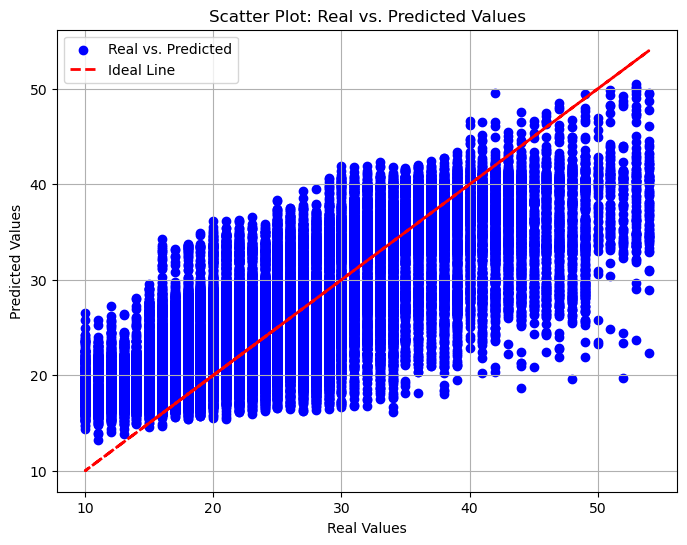

In [111]:
# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train['Time_taken(min)'], y_train['PREDICTED'], color='blue', label='Real vs. Predicted')
plt.plot(y_train['Time_taken(min)'], y_train['Time_taken(min)'], color='red', linestyle='--', linewidth=2, label='Ideal Line')

# Adding labels and title
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Real vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
print("Mean Squared Error = ", mean_squared_error(y_train['Time_taken(min)'], y_train['PREDICTED']))
print("Root Mean Squared Error = ", np.sqrt(mean_squared_error(y_train['Time_taken(min)'], y_train['PREDICTED'])))
print("R2 = ", r2_score(y_train['Time_taken(min)'], y_train['PREDICTED']))

Mean Squared Error =  37.94213969748466
Root Mean Squared Error =  6.159719124885863
R2 =  0.5603977537596757


In [113]:
y_test['PREDICTED'] = model.predict(X_test)
print("Mean Squared Error = ", mean_squared_error(y_test['Time_taken(min)'], y_test['PREDICTED']))
print("Root Mean Squared Error = ", np.sqrt(mean_squared_error(y_test['Time_taken(min)'], y_test['PREDICTED'])))
print("R2 = ", r2_score(y_test['Time_taken(min)'], y_test['PREDICTED']))

Mean Squared Error =  42.20845012076281
Root Mean Squared Error =  6.496803069261282
R2 =  0.5121536805993034


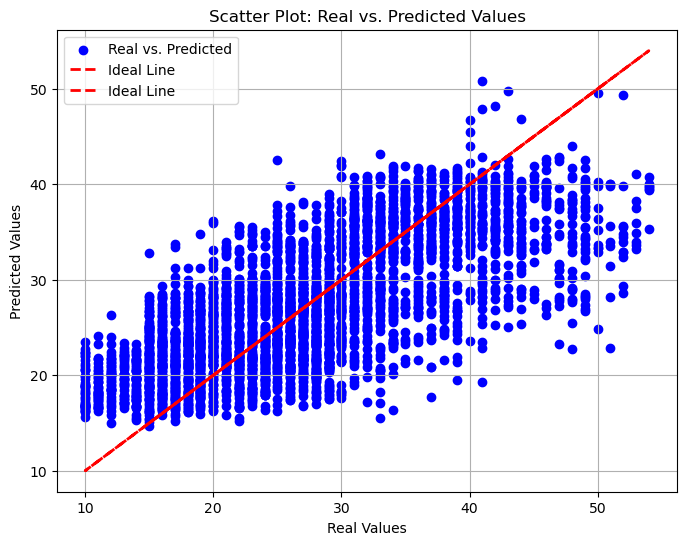

In [114]:
# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test['Time_taken(min)'], y_test['PREDICTED'], color='blue', label='Real vs. Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', linewidth=2, label='Ideal Line')

# Adding labels and title
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Real vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
X_test = pd.concat([X_test, y_test], axis=1)
X_test

,Delivery_person_Age,Delivery_person_Ratings,Delivery_Distance_km,is_motorcycle,Time_taken(min),PREDICTED
31628,-0.680593,-0.048961,1.568986,0.826145,39,32.806324
12706,-0.504713,0.847539,-1.416083,-1.210442,20,17.135889
24715,1.254086,1.146372,-1.403501,0.826145,24,24.405895
35720,0.726446,0.847539,-0.802487,0.826145,29,27.671062
18603,1.078206,-3.336127,1.510402,0.826145,40,36.569382
...,...,...,...,...,...,...
39947,0.902326,0.847539,-0.811776,-1.210442,28,24.030695
43696,-0.680593,-0.048961,0.122650,0.826145,25,22.243294
36432,1.254086,-0.646628,-0.195872,-1.210442,37,33.454689
4415,1.078206,0.249872,-0.802643,-1.210442,30,24.000519


Now, we have our model trained and tested using unseen data. By checking the visuals generated above, that compare the predicted values with their respective real values of time taken (min), we can see that the model built can identify, in a satisfactory way, the general behaviour of the target values. For example, the model can predict higher values when the real values are actually higher, which represents the basic explainability of a regression model.

Also, as we have seen before, our features can explain our target but not that greatly: a lot of variation exists in our dataset and lack of great explainability of the target using the available data and features, which means that, with the available data, it is very hard to get a model with amazing accuracy (for example R2 values close to 0.8 with test data). That means that, if we have a model that provides the slightest generalization and prediction power, it is a success. Also, in the current business problem, the stakeholders state that clients do not need an exact prediction of the time it will take for the delivery be completed, but just an ok approximation of this value.

As we can see, we got a R2 value of 0.51 on our testing data. For models that work with data such as ours (features with not so great explanation regarding the target variable), this is a good result! Generally, R2 values between 0.5 and 0.75 represent a good amount of variance explained by the model. With a R2 of 0.51 we are being able to explain more than 50% of the variability of the target variable through our features.

Another important point to talk about is if our model is healthy regarding overfitting: Is our model really learning? Comparing the results of the predictions when using training and testing data we see regression metrics (MSE and R2, for example) very similar across both situations: We are having results (performance) with unseen data very close to the results when using the training data. If we had way better metrics when using the training data compared to when using testing data, then we could say that our model was overfitting.